## Neural Networks and Deep Learning
***
**Third Homework by Luca Negri, Physics of Data**

# Homework 3: Reinforcement learning

## Introduction.

The aim of this homework is to create a Reinforcement Learning algorithm capable of completing a few tasks. The idea behind Reinforcement learning is to have an algorithm capable of acting on an enviroment and learning by observing the consequences of its actions. 

The basic building blocks of a reinforcement learning framework are:

+ The **Enviroment**, which is what we want to act on to accomplish a goal. At a time $t$ the enviroment can be in a certain state $s_t$  and will also give a certain reward $r_t$.
+ The **Agent** which, based on the observations of the state $s_t$ , will act on the enviroment througth an action $a_t$. The Agent decide which action to take based on the **Policy** function $\pi (s_t)$. It  will also recive a certain reward $r_t$ based on the results of its actions in relations to the accomplishment of the goal. The way that an agent estimates the rewards given a certain state is througth the **Value function** $v(s_t)$ 

So the aim of the Agent is then to **maximize** the accumulated rewards at each time step $t$, also called the **return**.

$G_t = R_t + \gamma R_{t+1} + \gamma^2 R_{t+2} + ... $ 

Where $\gamma$ is a parameter such that $0 < \gamma < 1 $ and weigths the future rewards with respect to the present. 

The strategy implemented to make the agent learn and act will be the **Q-learning** framework, where the agent learns to assign a value (or return) $q$ given a certain state-action pair througth the function $q(a_t,s_t)$.

Since the phase space of state-actions pairs is huge even for the easiest tasks, the learning of the $q$-function is a well suited task for a Deep neural network, which will  try to approximate it by giving in output a value $q$ to each of the possible actions $a_t$ given the observation $s_t$.


The homework is divided in two parts, characterized by the implementations of this reinfocement learning algorithms on two different tasks:

+ The **Cart pole** task, where the agent will try to balance a pole on a cart by moving the cart either left or rigth
+ The **Lunar Lander** task, where the agent will attempt to make a soft touch down on a simulated moon enviroment by firing the engines of a lander.





## Installation of the required packages

In [37]:
!pip3 install Box2D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
!pip3 install gym[Box_2D]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter

import matplotlib


from torch import nn
from collections import deque # this python module implements exactly what we need 

In [40]:
gym.make('LunarLander-v2')


<TimeLimit<LunarLander<LunarLander-v2>>>

## Colab enabling
Functions and packages needed for the animations to run on google colab

In [41]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 256 kB in 4s (60.0 kB/s)
Reading 

In [42]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [43]:
display = Display(visible=0, size=(1400, 900))
display.start()
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1


"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

## Replay memory

In order for the Neural network to be trained in order to predict the correct rewards, a memory of past states needs to be defined. The `Replaymemory` class below allows to store a tuple containing the past values of the state $s_t$, the action taken $a_t$, the state resulting from the action $s_{t+1}$ and the reward given from the enviroment $r_t$

Random batches of past experiences will be replayed to the updating algorithm. The memory has a maximum capacity, so that older samples that may not be relevant anymore will not be taken into account when training.


In [44]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
       self.memory.append( (state, action, next_state, reward) )

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

## Network architecture

Since we expect the tasks  to not have a very complicated landscape, the neural network size can be kept relatively small. It will have:

+ An input layer, of the size of $s_t$;
+ Two hidden layers, with sizes of respectively $N_{h1}$ and $N_{h2}$ nodes, by default both values are kept at 128 nodes;
+ An output layer of the size of $a_t$, where its values will try to predict the value $q$ depending on wich action the network chooses to take.

In [45]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim , Nh=(128,128),pDropout=0.0):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, Nh[0]),
                nn.Tanh(),
                nn.Dropout(pDropout),
                nn.Linear(Nh[0], Nh[1]),
                nn.Tanh(),
                nn.Dropout(pDropout),
                nn.Linear(Nh[1], action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

## Exploration profile

The action our agent will actually take will be dictated by the policy function $\pi(s_t)$. The policy will depend on the function $q(s_t,a_t)$, making so that the network is able to predict the possible future rewards and maximizing them. 

But during the first phases of training, where the network will not be calibrated yet, these actions may not actually give out the best rewards. A good policy in this phase would be to encourage the agent to take action that it considers "disadvantageous" to test the accuracies of its predictions. So we need to determine an **Exploration profile*** that will determine how "risky" the policy of the network will be.

The policy chosen will be to take ceratin actions with a probability proportional bto the softmax of the expected rewards. The temperature parameter of the softmax operation will determine how random each choice will actually be. 
+ high temperature -> uniform output 
+ low temperature -> just one output with probability 1

In [46]:
def choose_action_softmax(net, state, temperature,all_possible_actions):
    
#    if temperature < 0:
#        raise Exception('The temperature value must be greater than or equal to 0 ')


    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    if temperature == 0:
        return int(net_out.argmax()) , net_out.numpy()

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

## Training functions.

Here we define the functions needed to train the network

+ `update_step` will make a pass over a randomly sampled batch of the replay memory and update the network accordingly
+ `train_func` will go througth the whole exploration profile to simulate the different enviroments and trai the agent.

In the update_step function, in order to calculate all possible future rewards, the value that the network will actually try to approximate is, according to the Bellman equation 

$Q(s_t,a_t) = E[r + \gamma max (Q(s_{t+1},a_{t+1}))|s,a]$

Througth many iterations, this equation will converge to a stable state, and in the limit on infinite iterations will give the infinite horizon case for the estimated return values.

The algorithm takes here the assumption that in the next iteration the algorithm will take the most advantageous move, so it does not take into consideration the actual policy of the agent. This is called an off policy algorithm and will take more risk compared to an on policy one.

To estimate the behaviour of the network on the future step, it is not advisable to use the current state of the policy network, in order to not create too much autocorrelation between training step. To avoid this a second **Target network** is used to accomplish this task. The target network will be updated with the parameters of the policy network every few steps.

At last, the training loss will be the huber loss, which takes the form of a L2 loss near 0 but is a L1 loss further away. This allows the loss to be much more "forgiving" of big errors, which are quite common in Reinforcement learning

In [47]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor(np.array([s[0] for s in batch]), dtype=torch.float32)
    actions     = torch.tensor(np.array([s[1] for s in batch]), dtype=torch.int64)
    rewards     = torch.tensor(np.array([s[3] for s in batch]), dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor(np.array([s[2] for s in batch if s[2] is not None]), dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor(np.array([s[2] is not None for s in batch]), dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

    return loss.detach().numpy()

In [48]:
def train_func(env,policy_net,target_net,exploration_profile,loss_fn,optimizer,replay_mem, all_possible_actions,
               gamma = 0.97,target_net_update_steps=10,batch_size = 128, bad_state_penalty = 0 ,
               min_samples_for_training=1000,pos_weight=1,score_counter=1/500,verbose=0,record_rewards=False):
  env.seed(0) # Set a random seed for the environment (reproducible results)

  tot_episodes_scores  = []
  tot_episodes_rewards = []

  train_losses = []

  final_train_losses_per_episode = []


  for episode_num, tau in enumerate(tqdm(exploration_profile)):

      # Reset the environment and get the initial state
      state = env.reset()
      # Reset the score. The final score will be the total amount of steps before the pole falls
      score = 0
      done = False
      train_loss = 0
      tot_reward = 0
      # Go on until the pole falls off
      while not done:

        # Choose the action following the policy
        action, q_values = choose_action_softmax(policy_net, state , tau ,all_possible_actions)
        
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)

        # Update the final score (+1 for each step)
        score += 1

        reward = reward - pos_weight * np.abs(state[0])  + score*score_counter


        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty if score<500 else 0
            next_state = None
        tot_reward += reward

        # Update the replay memory
        replay_mem.push(state, action, next_state, reward)

        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            train_loss = update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)
            train_losses.append(train_loss)

        # Visually render the environment (disable to speed up the training)
        #env.render()

        # Set the current state for the next iteration
        state = next_state

      # Update the target network every target_net_update_steps episodes
      final_train_losses_per_episode.append(train_loss)
      if episode_num % target_net_update_steps == 0:
          #print('Updating target network...')
          target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

      
      if verbose>0: # Print the final score
        if record_rewards:
          print(f"EPISODE: {episode_num + 1} - FINAL REWARD: {int(tot_reward)} - Temperature: {tau:.4f}") 
        else:
          print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau:.4f}") 

      tot_episodes_scores.append(score)
      tot_episodes_rewards.append(tot_reward)
  env.close()
  return tot_episodes_scores,tot_episodes_rewards if record_rewards else tot_episodes_scores

# The cart pole enviroment

The cart pole is a `gym` enviroment. The aim is to keep a pole from falling by nudging left or rigth the cart on which it sits on. The space $s_t$ is four dimensional and consist of:

+ The cart x position
+ The cart x-velocity 
+ The pole angle (from the perpendicular to the ground)
+ the pole angular velocity

The possible actions are
+ Push the cart rigth
+ Push the cart left

The rewards will be a +1 per each timestep the pole is uprigth.

A costum set of rewards will also be explored:
+ A bad state penalty, that will remove points if the pole falls down
+ A penalty proportional to the distance to the center, to avoid the cart from exiting the simulation space.
+ A therm that is proportional to the timestep number, to encourage the long duration of the simulation. Even if in spirit such therm is accounted for in the long therm rewards calculation of the Bellamn equation, adding this reward showed better results in training



In [49]:
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


## Exploration profile tests

The temperature will have an exponential decay that goes like

$$
\text{softmax_temperature}  = \text{initial_temperature} * \text{exp_decay}^i \qquad \text{for $i$ = 1, 2, ..., num_iterations } 
$$

Down here it is possible to see an example of an exploration profile and the effect of the softmax on a random vector.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


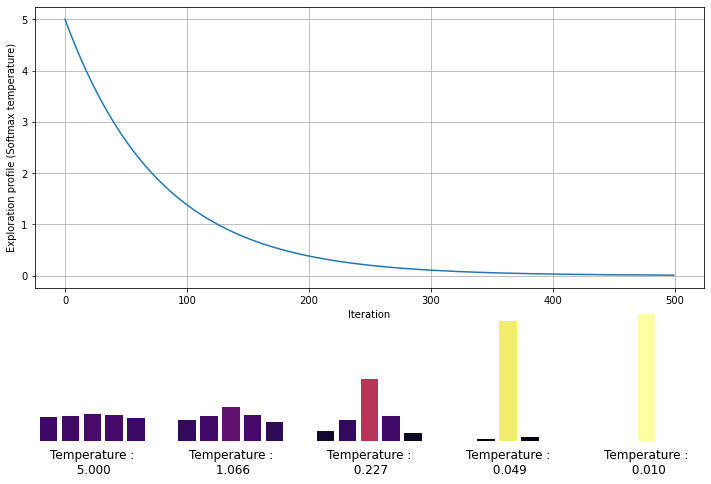

In [53]:
### Define exploration profile
initial_value = 5
num_iterations = 500
decay = 4
exp_decay = np.exp(-np.log(initial_value) / num_iterations * decay) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

random_vec = np.random.random(5)

plt.figure(figsize=(12,8))
cmap = matplotlib.cm.get_cmap('inferno')

### Plot exploration profile
plt.subplot2grid((3,5),(0,0),colspan=5,rowspan=2)
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')
for i in range(5):
    ax = plt.subplot2grid((3,5),(2,i))
    softmax_values = nn.functional.softmax(torch.tensor(random_vec/exploration_profile[i*100]))

    ax.bar(np.arange(5),softmax_values,color=cmap(softmax_values.numpy()))
    ax.set_ylim(0,1)

    ax.set_title(f'Temperature :\n {exploration_profile[i*120]:.3f}',y=-0.3)
    ax.axis('off')

plt.show()

## Study of how the exploration profile impacts learning.

To see which exploration profile will yeld the best results, 3 different ones will be tested, all with different exploration/exploitation balances. To do this, a different decay parameter has been chosen for the temperature. The parameter chosen will be $[2,4,10]$

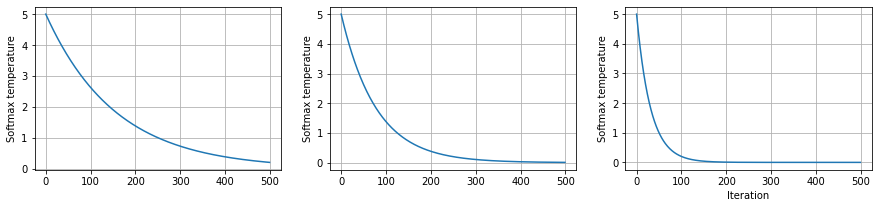

In [ ]:
initial_value = 5
num_iterations = 500

exploration_profiles = []

decays  = [2,4,10]
fig,ax = plt.subplots(1,3,figsize  = [15,3])

for i,decay in enumerate(decays):

  exp_decay = np.exp(-np.log(initial_value) / num_iterations * decay)
  exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]
  exploration_profiles.append(exploration_profile)



  ### Plot exploration profile
  ax[i].plot(exploration_profile)
  ax[i].grid()
  ax[i].set_ylabel('Softmax temperature')

ax[i].set_xlabel('Iteration')
plt.show()

Here we actually perform the training over the 3 exploration profiles. The parameter are the same as the laboratory notebook, with the exception of the reward function and the optimizer, where the Adam algorithm was chosen, with a weigth decay of 1e-4.  

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000 
all_possible_actions = np.arange(0,action_space_dim)

list_episode_scores  = []

for exploration_profile in exploration_profiles:

  ### Initialize the replay memory
  replay_mem = ReplayMemory(replay_memory_capacity)    

  ### Initialize the policy network
  policy_net = DQN(state_space_dim, action_space_dim)

  ### Define an action space

  target_net = DQN(state_space_dim, action_space_dim)
  target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

  optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr, weight_decay=1e-4) # The optimizer will update ONLY the parameters of the policy network

  loss_fn = nn.SmoothL1Loss()

  scores = train_func(env,policy_net,target_net,exploration_profile,loss_fn,optimizer,replay_mem, all_possible_actions,
                gamma=gamma, target_net_update_steps=target_net_update_steps,
                batch_size = batch_size, bad_state_penalty = bad_state_penalty ,
                min_samples_for_training=min_samples_for_training,verbose=0)
  list_episode_scores.append(scores)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

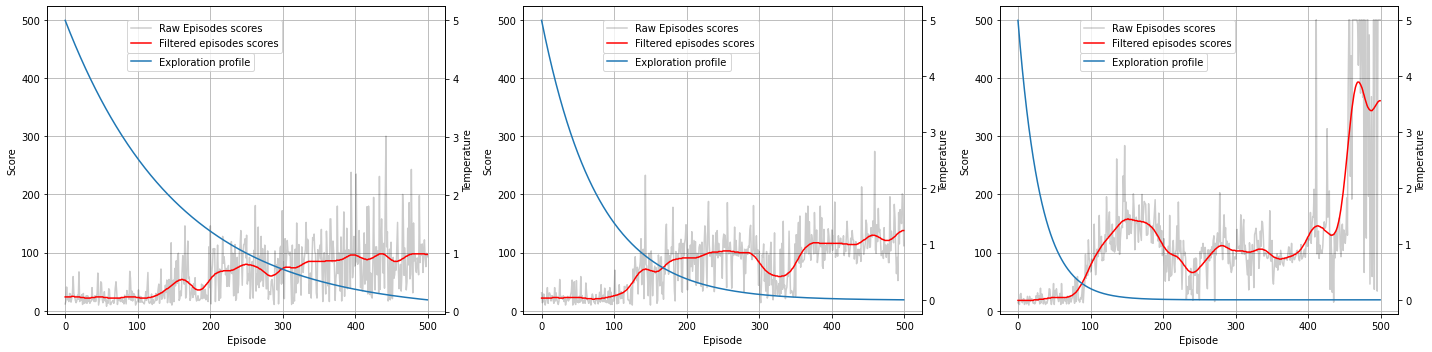

In [ ]:
fig,ax = plt.subplots(1,3,figsize=[20,5])
for i,scores in enumerate(list_episode_scores):
  scores_cleaned = gaussian_filter(scores,10)
  ax[i].plot(scores,'k',alpha=0.2,label='Raw Episodes scores')
  ax[i].plot(scores_cleaned,color='red',label='Filtered episodes scores')
  ax[i].set_ylim(-5,523)
  ax[i].set_xlabel('Episode')
  ax[i].set_ylabel('Score')
  ax[i].grid()
  ax2 = plt.twinx(ax[i])
  ax2.plot(exploration_profiles[i],label='Exploration profile')
  ax2.set_ylabel('Temperature')
  ax[i].legend(loc=[0.2,0.85])
  ax2.legend(  loc=[0.2,0.79])
plt.tight_layout()
plt.show()

Here are the scores for each episodes compared to the exploration profile. The red line represent a gaussian-filtered version of the scores to make them more readable. 

It seems that the best performing one is the one with the fastest decay, so the one that favours exploitation. So now we will perform another training with this exploration profile. 

After a few tries, some other parameters have been modified with respect to the class notebook: the gamma parameter is set at 0.99 to promote long therm knowledge of the system, the total training epoisodes are now just 500 and a bad state penalty of -1 to the reward is added, meaning that the reward will be -1 if the pole falls. 

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = -1   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000 
all_possible_actions = np.arange(0,action_space_dim)

### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Define an action space
all_possible_actions = np.arange(0,action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr, weight_decay=1e-4) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

scores = train_func(env,policy_net,target_net,exploration_profile,loss_fn,optimizer,replay_mem, all_possible_actions,
            gamma=gamma,batch_size = batch_size,
            bad_state_penalty = bad_state_penalty,pos_weight=0,score_counter=0,verbose=0)

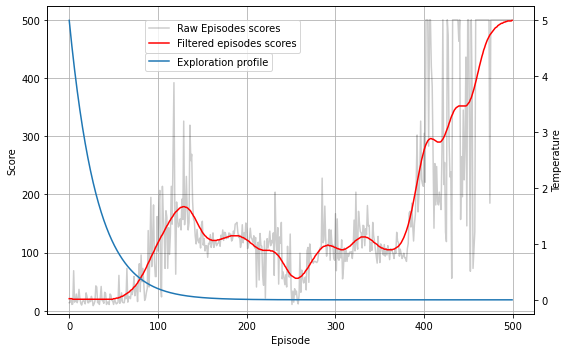

In [ ]:
fig,ax = plt.subplots(figsize=[8,5])
scores_cleaned = gaussian_filter(scores,10)
ax.plot(scores,'k',alpha=0.2,label='Raw Episodes scores')
ax.plot(scores_cleaned,color='red',label='Filtered episodes scores')
ax.set_ylim(-5,523)
ax.set_xlabel('Episode')
ax.set_ylabel('Score')
ax.grid()
ax2 = plt.twinx(ax)
ax2.plot(exploration_profile,label='Exploration profile')
ax2.set_ylabel('Temperature')
ax.legend(loc=[0.2,0.85])
ax2.legend(  loc=[0.2,0.79])
plt.tight_layout()
plt.show()

With these other small adjustment, the agent is able to get even better than before, by getting to the maximum score (500) every time. In the cell below it is possible to see some examples on how the network is able to perform.

In [54]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, 0,all_possible_actions)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    #print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

Since i doubt that the mp4 videos will work, down here i tried to put an example of the agent working in the form of a gif

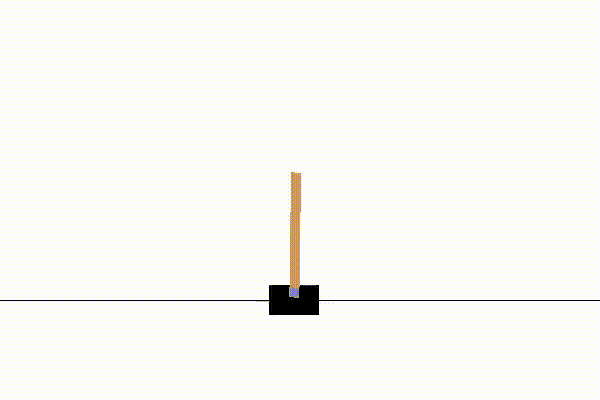

In [ ]:
show_videos()


SHOWING VIDEO video/openaigym.video.3.61.video000000.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000001.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000002.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000003.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000004.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000005.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000006.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000007.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000008.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000009.mp4


In [ ]:
torch.save(policy_net.state_dict(),'policy_net_params_cartpole.pth')

# Lunar Lander

Now the task that the agent will try to perform is to touch down softly on the moon, by firing the engines of a lander in free fall.  

The observation space consists of:
+ The x & y position of the lander
+ The x & y velocities
+ Angle and angular velocity
+ Two booleans indicating for each leg if it is touching the ground

The lander can also take four actions:

+ Fire main  engine (pointing down)
+ Fire left engine
+ Fire left engine
+ Do nothing

The reward has different components, accounting to:
+ A loss of -100 if the lander crashes
+ A reward of 200 if the landing occurs in the correct spot
+ Reward of +10 for each leg that makes contact
+ Loss for moving away from the landing pad
+ Small losses for firing the engines

The reward has also been modified to speed up convergence. In particular the squared distance to the landing pad is subtracted to the reward, to incentivize the lander to move towards the landing pad. Even if a similar reward is implemented by default in the enviroment, adding this quadratic therm seemed to speed up convergence to the solution.

In [15]:
env = gym.make('LunarLander-v2')
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 8
ACTION SPACE SIZE: 4


Here the lander will make random moves each turn, this is just to show the enviroment.

In [16]:
env = gym.make('LunarLander-v2') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes

for num_episode in range(3): 
    positions = []
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1 ,2 ,3])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      positions.append(next_state[0]**2+next_state[1]**2)
      
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


EPISODE 1 - FINAL SCORE: -337.48495727285365
EPISODE 2 - FINAL SCORE: -110.1233194565218
EPISODE 3 - FINAL SCORE: -283.7934752057328


In [25]:
show_videos()


SHOWING VIDEO video/openaigym.video.2.1411.video000000.mp4



SHOWING VIDEO video/openaigym.video.2.1411.video000001.mp4



SHOWING VIDEO video/openaigym.video.2.1411.video000002.mp4


This is the exploration profile chosen for this task. Is a bit longer than that of previous task (600 episodes) and takes a bit more risks, but after a few trial and errors this seemed to be the most effective.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


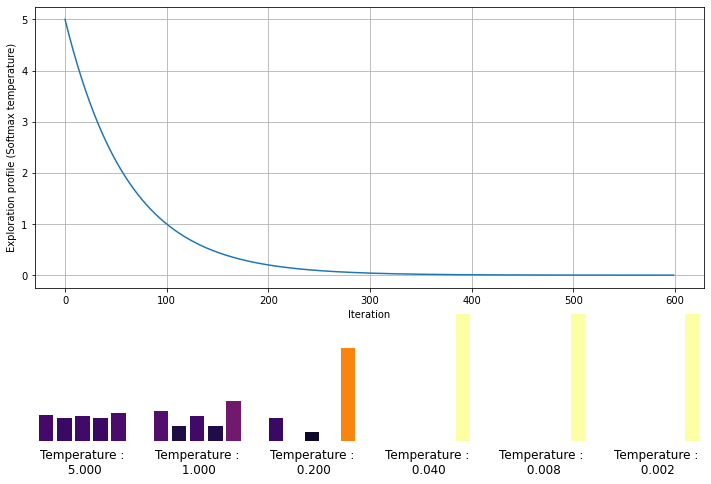

In [2]:
### Define exploration profile
initial_value = 5
num_iterations = 600
decay = 6
exp_decay = np.exp(-np.log(initial_value) / num_iterations * decay) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

random_vec = np.random.random(5)

plt.figure(figsize=(12,8))
cmap = matplotlib.cm.get_cmap('inferno')

### Plot exploration profile
plt.subplot2grid((3,6),(0,0),colspan=6,rowspan=2)
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')
for i in range(6):
    ax = plt.subplot2grid((3,6),(2,i))
    softmax_values = nn.functional.softmax(torch.tensor(random_vec/exploration_profile[i*100]))

    ax.bar(np.arange(5),softmax_values,color=cmap(softmax_values.numpy()))

    ax.set_title(f'Temperature :\n {exploration_profile[i*100]:.3f}',y=-0.3)
    ax.set_ylim(0,1)
    ax.axis('off')

plt.show()

And down below the final training is present. Almost all of the training parameters have been kept the same as the previous task, the biggest difference is that the network now has 64 nodes for each hidden layer, when before it had 128. This change seemed to speed up convergence, probably because it helped the network to generalize its findings.

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000 
all_possible_actions = np.arange(0,action_space_dim)



### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim,Nh=(64,64))

### Define an action space

target_net = DQN(state_space_dim, action_space_dim,Nh=(64,64))
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr, weight_decay=1e-4) # The optimizer will update ONLY the parameters of the policy network

loss_fn = nn.SmoothL1Loss()

env.seed(0) # Set a random seed for the environment (reproducible results)

tot_episodes_scores  = []
tot_episodes_rewards = []

train_losses = []

final_train_losses_per_episode = []

score_counter = 0

pos_weigth  = 1

final_rewards = []

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    train_loss = 0
    tot_reward = 0
    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state , tau ,all_possible_actions)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # Update the final score (+1 for each step)
      score += 1

      distance  = next_state[0]**2 + next_state[1]**2

      reward = reward + score*score_counter - distance*pos_weigth


      # Apply penalty for bad state
      if done:  
          reward += bad_state_penalty 
          next_state = None
          final_rewards.append(reward)
      tot_reward += reward

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          train_loss = update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)
          train_losses.append(train_loss)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    final_train_losses_per_episode.append(train_loss)
    if episode_num % target_net_update_steps == 0:
        #print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    


    print(f"EPISODE: {episode_num + 1} - FINAL REWARD: {int(tot_reward)} - Temperature: {tau:.4f}") 


    tot_episodes_scores.append(score)
    tot_episodes_rewards.append(tot_reward)
env.close()


Since the reward score may not reflect correctly what is happening (since the more time it takes the more it looses point by virtue of the costum therm added to the reward) a new plot was chosen to be shown: the final reward.
This therm should be -100 if the lander crashed, around 0 if it had reached the time limit and 100 if it had succeded in a soft landing. So seeing the distribution of each of theese outcomes as a function of the episode might gives us some better insigth on the performance of the network. 

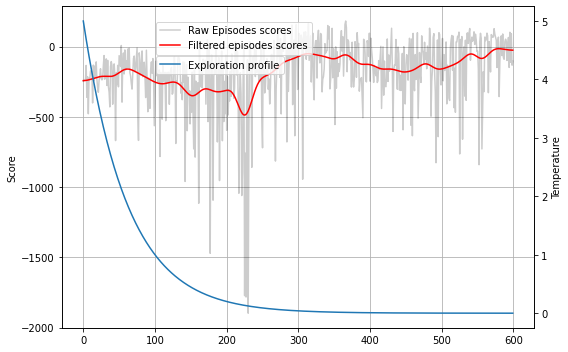

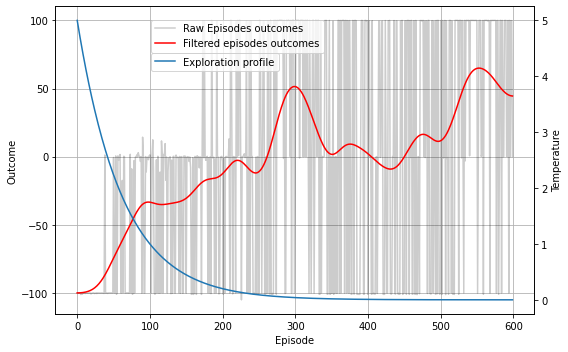

In [33]:
fig,ax = plt.subplots(figsize=[8,5])
scores_cleaned = gaussian_filter(tot_episodes_rewards,10)
ax.plot(tot_episodes_rewards,'k',alpha=0.2,label='Raw Episodes scores')
ax.plot(scores_cleaned,color='red',label='Filtered episodes scores')
#ax.set_ylim(-5,523)
ax.set_ylabel('Score')
ax.grid()
ax2 = plt.twinx(ax)
ax2.plot(exploration_profile,label='Exploration profile')
ax2.set_ylabel('Temperature')
ax.legend(loc=[0.2,0.85])
ax2.legend(  loc=[0.2,0.79])
plt.tight_layout()
plt.show()

fig,ax = plt.subplots(figsize=[8,5])
scores_cleaned = gaussian_filter(final_rewards,15)
ax.plot(final_rewards,'k',alpha=0.2,label='Raw Episodes outcomes')
ax.plot(scores_cleaned,color='red',label='Filtered episodes outcomes')
#ax.set_ylim(-5,523)
ax.set_xlabel('Episode')
ax.set_ylabel('Outcome')
ax.grid()
ax2 = plt.twinx(ax)
ax2.plot(exploration_profile,label='Exploration profile')
ax2.set_ylabel('Temperature')
ax.legend(loc=[0.2,0.85])
ax2.legend(  loc=[0.2,0.79])
plt.tight_layout()
plt.show()

As it is possible to see towards the end the agent is able to solve the task most of the time. Below is possible to see some simulation done on the final network.

In [34]:
# Initialize the Gym environment
env = gym.make('LunarLander-v2') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode
distances = []
# Let's try for a total of 10 episodes
for num_episode in range(8): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    distance = []
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, 0,all_possible_actions)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward
      # Set the current state for the next iteration
      state = next_state
      distance.append(next_state[0]**2+ next_state[1]**2)
      # Check if the episode ended (the pole fell down)
    # Print the final score
    distances.append(distance)
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 78.02639536207124
EPISODE 2 - FINAL SCORE: 214.59861933855422
EPISODE 3 - FINAL SCORE: 199.41302053453396
EPISODE 4 - FINAL SCORE: 231.5629799112063
EPISODE 5 - FINAL SCORE: 189.62968759338935
EPISODE 6 - FINAL SCORE: 147.4105235862553
EPISODE 7 - FINAL SCORE: 161.95110652535075
EPISODE 8 - FINAL SCORE: 263.00676991033345


Same as above, to avoid the problem of mp4 video i will put here a gif that will hopefully work.

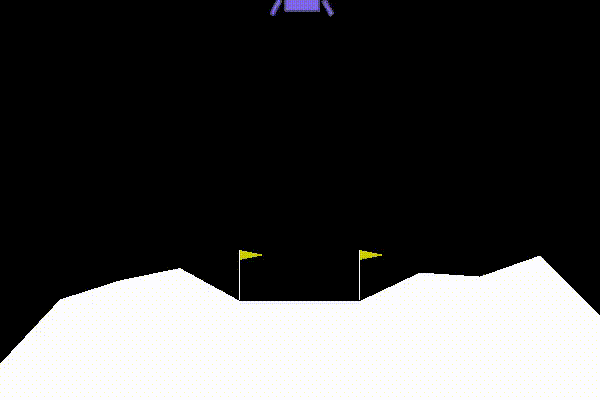

In [35]:
show_videos()


SHOWING VIDEO video/openaigym.video.2.59.video000000.mp4



SHOWING VIDEO video/openaigym.video.2.59.video000001.mp4



SHOWING VIDEO video/openaigym.video.2.59.video000002.mp4



SHOWING VIDEO video/openaigym.video.2.59.video000003.mp4



SHOWING VIDEO video/openaigym.video.2.59.video000004.mp4



SHOWING VIDEO video/openaigym.video.2.59.video000005.mp4



SHOWING VIDEO video/openaigym.video.2.59.video000006.mp4



SHOWING VIDEO video/openaigym.video.2.59.video000007.mp4


In [32]:
torch.save(policy_net.state_dict(),'policy_net_paramsLunarLander.pth')